In [1]:
from pathlib import Path
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
source_1_file = Path("excel_files\source_1.xlsx")
source_2_file = Path("excel_files\source_2.xlsx")

source_1_df = pd.read_excel(source_1_file, header=None)
source_2_df = pd.read_excel(source_2_file, header=None)

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Assume source_1_df and source_2_df are loaded

# Drop unnecessary columns
source_1_df = source_1_df.drop(source_1_df.columns[:6], axis=1)
source_1_df.columns = [f'DP-{i}' for i in range(1, 3401)]
source_1_df['source'] = 0  # Source 1

source_2_df = source_2_df.drop(source_2_df.columns[:6], axis=1)
source_2_df.columns = [f'DP-{i}' for i in range(1, 3401)]
source_2_df['source'] = 1  # Source 2

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

# Combine both sources into a single DataFrame
dataframe = pd.concat([source_1_df, source_2_df], axis=0).reset_index(drop=True)

# Separate features (X) and labels (Y)
Y = dataframe['source'].to_numpy()
X = dataframe.drop(columns=['source']).to_numpy()

# Reshape the data to match the input shape (samples, 3400, 1) without scaling
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)  # Shape (samples, 3400, 1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, Y, test_size=0.3, random_state=42, stratify=Y)

# Build the hybrid CNN-LSTM model
hybrid_model = Sequential()

# CNN layers
hybrid_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(3400, 1)))
hybrid_model.add(MaxPooling1D(pool_size=2))
hybrid_model.add(BatchNormalization())

# Second Conv1D layer
hybrid_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
hybrid_model.add(MaxPooling1D(pool_size=2))
hybrid_model.add(BatchNormalization())

# LSTM layers
hybrid_model.add(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
hybrid_model.add(BatchNormalization())
hybrid_model.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
hybrid_model.add(BatchNormalization())
hybrid_model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
hybrid_model.add(BatchNormalization())

# Fully connected layer
hybrid_model.add(Dense(64, activation='relu'))
hybrid_model.add(Dropout(0.3))

# Output layer for binary classification
hybrid_model.add(Dense(1, activation='sigmoid'))

# Compile the model
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     loss='binary_crossentropy', metrics=['accuracy'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = hybrid_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = hybrid_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')

Epoch 1/50
2/2 [==============================] - 24s 6s/step - loss: 0.7534 - accuracy: 0.5000 - val_loss: 0.6918 - val_accuracy: 0.6429
Epoch 2/50
2/2 [==============================] - 16s 6s/step - loss: 0.6862 - accuracy: 0.5714 - val_loss: 0.6901 - val_accuracy: 0.6429
Epoch 3/50
2/2 [==============================] - 15s 6s/step - loss: 0.6843 - accuracy: 0.4821 - val_loss: 0.6879 - val_accuracy: 0.6429
Epoch 4/50
2/2 [==============================] - 17s 6s/step - loss: 0.6836 - accuracy: 0.5179 - val_loss: 0.6856 - val_accuracy: 0.6429
Epoch 5/50
2/2 [==============================] - 15s 6s/step - loss: 0.6337 - accuracy: 0.6429 - val_loss: 0.6832 - val_accuracy: 0.6429
Epoch 6/50
2/2 [==============================] - 17s 7s/step - loss: 0.5733 - accuracy: 0.7143 - val_loss: 0.6809 - val_accuracy: 0.6429
Epoch 7/50
2/2 [==============================] - 18s 7s/step - loss: 0.6305 - accuracy: 0.5536 - val_loss: 0.6786 - val_accuracy: 0.6429
Epoch 8/50
2/2 [==================

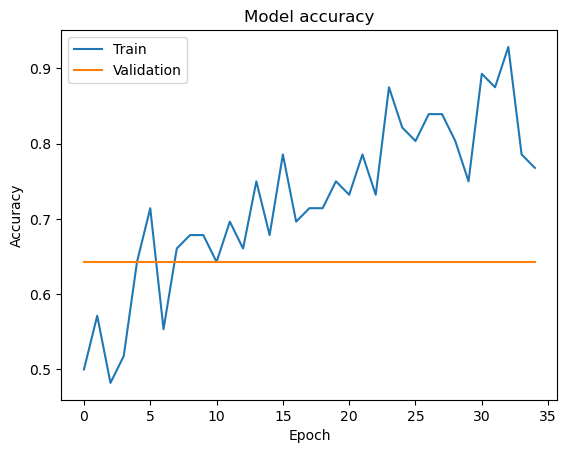

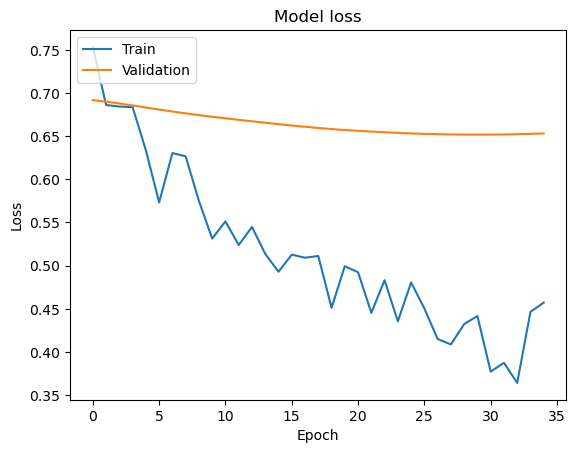

In [6]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [9]:
# Testing on Excel File
def test_excel_file(test_file, model):
    test_df = pd.read_excel(test_file, header=None)
    total_rows = test_df.shape[0]
    total_columns = test_df.shape[1]
    signal_columns = 3400
    
    test_df = test_df.drop(test_df.columns[:6], axis=1)
    
    for counter in range(total_rows):
        sample = test_df.iloc[counter].to_numpy()
        # Reshape the sample to match the input shape of the model
        sample_reshaped = sample.reshape(1, 3400, 1)
        # Predict the class (returns a probability)
        prediction = model.predict(sample_reshaped)
        if prediction > 0.5:
            source = 1
        else:
            source = 0
        print(f'Predicted Source {source}')

In [10]:
test_file = Path(r"D:\Study\CI\ComputationalIntelligence\excel_files\test_file.xlsx")
test_excel_file(test_file, hybrid_model) 

1/1 [==============================] - 1s 956ms/step
Predicted Source 0
1/1 [==============================] - 0s 281ms/step
Predicted Source 0
1/1 [==============================] - 0s 272ms/step
Predicted Source 0
1/1 [==============================] - 0s 274ms/step
Predicted Source 0
1/1 [==============================] - 0s 273ms/step
Predicted Source 0
1/1 [==============================] - 0s 266ms/step
Predicted Source 0
1/1 [==============================] - 0s 272ms/step
Predicted Source 0
1/1 [==============================] - 0s 268ms/step
Predicted Source 0
1/1 [==============================] - 0s 277ms/step
Predicted Source 0
1/1 [==============================] - 0s 265ms/step
Predicted Source 0
